# Classification

In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

Features shape: (70000, 784)
Digit label: 5


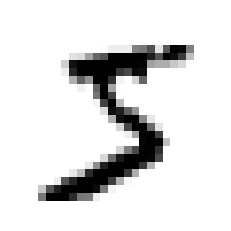

In [24]:
mnist = fetch_openml("mnist_784", version=1)
print(
    mnist.keys() # type: ignore
)

X, y = mnist["data"], mnist["target"] # type: ignore
y = y.astype(np.uint8)
print(f"Features shape: {X.shape}")

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)

print(f"Digit label: {y.iloc[0]}")
plt.imshow(
    some_digit_image,
    cmap=mpl.cm.binary, # type: ignore
    interpolation="nearest"
)
plt.axis("off")
plt.show()

The MNIST dataset is actually already split into a training set (the first 60,000 images)
and a test set (the last 10,000 images)  
The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some dig its). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

In [26]:
X_train, X_test, y_train, y_test = X.iloc[:60_000], X.iloc[60_000:], y.iloc[:60_000], y.iloc[60_000:]

## Training a Binary Classiier
Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5

In [28]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

### Confusion Matrix

In [36]:
# returns, for each element in the input, the prediction that was obtained
# for that element when it was in the test set
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### Precision and Recall

In [39]:
print(f"Precision = {precision_score(y_train_5, y_train_pred)}")
print(f"Recall = {recall_score(y_train_5, y_train_pred)}")

Precision = 0.8370879772350012
Recall = 0.6511713705958311


In [33]:
"""
The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions
"""

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

########## Implementing cross-validation ##########

skfolds = StratifiedKFold(
    n_splits=3,
    random_state=42,
    shuffle=True,
)

for train_indexes, test_indexes in skfolds.split(X_train, y_train_5):
    clone_clf: SGDClassifier = clone(sgd_clf) # type: ignore
    X_train_fold = X_train.iloc[train_indexes]
    y_train_fold = y_train_5.iloc[train_indexes]
    X_test_fold = X_train.iloc[test_indexes]
    y_test_fold = y_train_5.iloc[test_indexes]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))


0.9669
0.91625
0.96785
